<p style="background-color:orange;font-family:newtimeroman;font-size:200%;color:white;text-align:center;border-radius:10px 10px;"><b>Decision Tree - Regression</b></p>

# <font color='orange'> <b>Importing Libraries</b><font color='black'>  

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import cross_validate, cross_val_score
from yellowbrick.regressor import PredictionError, ResidualsPlot
from yellowbrick.features import RadViz
from sklearn.tree import plot_tree

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)
pd.set_option('display.width', 1000)
pd.options.display.float_format = '{:.3f}'.format
plt.rcParams["figure.figsize"] = (9, 5)

import warnings
warnings.filterwarnings('ignore')

# <font color='orange'> <b>Loading The Dataset</b><font color='black'>  

In [2]:
df0 = pd.read_csv("/kaggle/input/extensive-used-car-price-for-predictive-modeling/car_dataset.csv")
df = df0.copy()

df.head()

,Car_Name,Year,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner
0,ritz,2014,3.350,5.590,27000,Petrol,Dealer,Manual,0
1,sx4,2013,4.750,9.540,43000,Diesel,Dealer,Manual,0
2,ciaz,2017,7.250,9.850,6900,Petrol,Dealer,Manual,0
3,wagon r,2011,2.850,4.150,5200,Petrol,Dealer,Manual,0
4,swift,2014,4.600,6.870,42450,Diesel,Dealer,Manual,0


# <font color='orange'> <b>Understanding Data & EDA</b><font color='black'>  

In [3]:
df.shape

(301, 9)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301 entries, 0 to 300
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Car_Name       301 non-null    object 
 1   Year           301 non-null    int64  
 2   Selling_Price  301 non-null    float64
 3   Present_Price  301 non-null    float64
 4   Kms_Driven     301 non-null    int64  
 5   Fuel_Type      301 non-null    object 
 6   Seller_Type    301 non-null    object 
 7   Transmission   301 non-null    object 
 8   Owner          301 non-null    int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 21.3+ KB


In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Year,301.000,2013.628,2.892,2003.000,2012.000,2014.000,2016.000,2018.000
Selling_Price,301.000,4.661,5.083,0.100,0.900,3.600,6.000,35.000
Present_Price,301.000,7.628,8.644,0.320,1.200,6.400,9.900,92.600
Kms_Driven,301.000,36947.206,38886.884,500.000,15000.000,32000.000,48767.000,500000.000
Owner,301.000,0.043,0.248,0.000,0.000,0.000,0.000,3.000


In [6]:
df.describe(include="object").T

,count,unique,top,freq
Car_Name,301,98,city,26
Fuel_Type,301,3,Petrol,239
Seller_Type,301,2,Dealer,195
Transmission,301,2,Manual,261


In [7]:
numeric_df = df.select_dtypes(include=['number'])
corr_matrix = numeric_df.corr()

fig = px.imshow(corr_matrix, text_auto='.2f', aspect="auto", color_continuous_scale='RdBu_r')
fig.show()

In [8]:
df["Vehicle_Age"] = 2025 - df.Year
df.head()

,Car_Name,Year,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner,Vehicle_Age
0,ritz,2014,3.350,5.590,27000,Petrol,Dealer,Manual,0,11
1,sx4,2013,4.750,9.540,43000,Diesel,Dealer,Manual,0,12
2,ciaz,2017,7.250,9.850,6900,Petrol,Dealer,Manual,0,8
3,wagon r,2011,2.850,4.150,5200,Petrol,Dealer,Manual,0,14
4,swift,2014,4.600,6.870,42450,Diesel,Dealer,Manual,0,11


In [9]:
def unique_values(df, columns):
    """Prints unique values and their counts for specific columns in the DataFrame."""

    for column_name in columns:
        print(f"Column: {column_name}\n{'-'*30}")
        unique_vals = df[column_name].unique()
        value_counts = df[column_name].value_counts()
        print(f"Unique Values ({len(unique_vals)}): {unique_vals}\n")
        print(f"Value Counts:\n{value_counts}\n{'='*40}\n")

In [10]:
cat_features = df.select_dtypes(include='object').columns
unique_values(df, cat_features)

Column: Car_Name
------------------------------
Unique Values (98): ['ritz' 'sx4' 'ciaz' 'wagon r' 'swift' 'vitara brezza' 's cross'
 'alto 800' 'ertiga' 'dzire' 'alto k10' 'ignis' '800' 'baleno' 'omni'
 'fortuner' 'innova' 'corolla altis' 'etios cross' 'etios g' 'etios liva'
 'corolla' 'etios gd' 'camry' 'land cruiser' 'Royal Enfield Thunder 500'
 'UM Renegade Mojave' 'KTM RC200' 'Bajaj Dominar 400'
 'Royal Enfield Classic 350' 'KTM RC390' 'Hyosung GT250R'
 'Royal Enfield Thunder 350' 'KTM 390 Duke ' 'Mahindra Mojo XT300'
 'Bajaj Pulsar RS200' 'Royal Enfield Bullet 350'
 'Royal Enfield Classic 500' 'Bajaj Avenger 220' 'Bajaj Avenger 150'
 'Honda CB Hornet 160R' 'Yamaha FZ S V 2.0' 'Yamaha FZ 16'
 'TVS Apache RTR 160' 'Bajaj Pulsar 150' 'Honda CBR 150' 'Hero Extreme'
 'Bajaj Avenger 220 dtsi' 'Bajaj Avenger 150 street' 'Yamaha FZ  v 2.0'
 'Bajaj Pulsar  NS 200' 'Bajaj Pulsar 220 F' 'TVS Apache RTR 180'
 'Hero Passion X pro' 'Bajaj Pulsar NS 200' 'Yamaha Fazer '
 'Honda Activa 4G' 'TVS 

In [11]:
df.drop(columns=["Car_Name", "Year"], inplace=True)

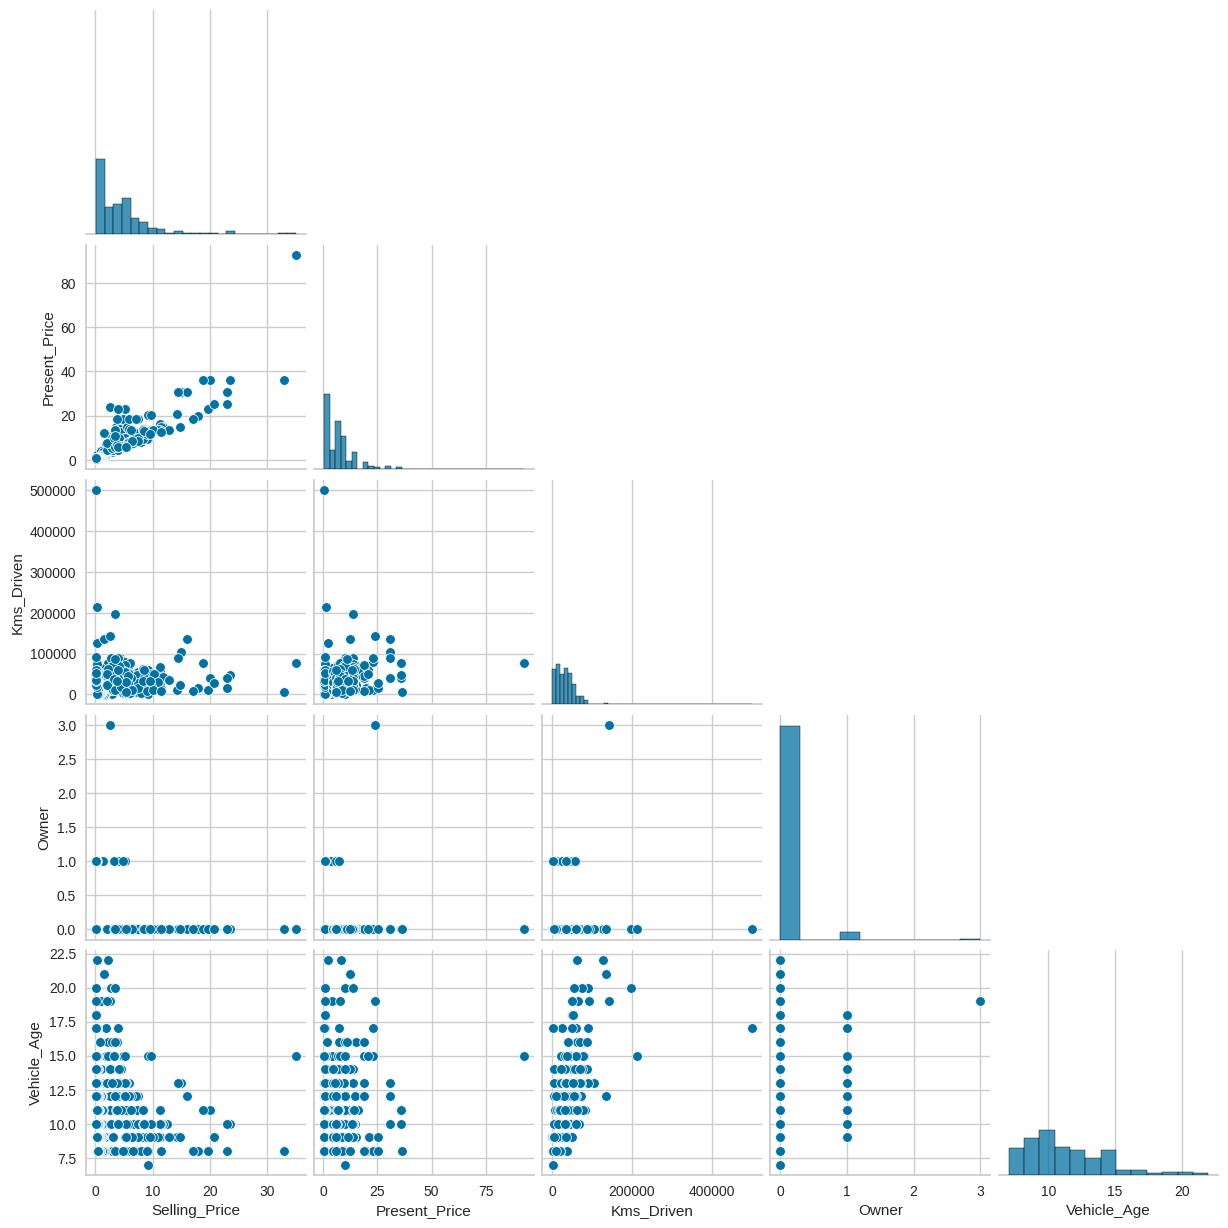

In [12]:
sns.pairplot(df, corner=True)
plt.show()

In [13]:
fig = ff.create_distplot([df['Selling_Price']], ['Selling Price'],
                         show_hist=True,
                         show_rug=True)

fig.update_layout(
    title_text='Distribution and Box Plot of Selling Prices',
    title_font_size=20,
    xaxis_title_text='Selling Price',
    yaxis_title_text='Density',
    template='plotly_white',
    width=1000,
    height=500,
    bargap=0.01
)

fig.show()

In [14]:
box_plot = go.Box(y=df['Selling_Price'], name='Selling Price')

fig = go.Figure(data=[box_plot])
fig.update_layout(title='Selling Price Box Plot')
fig.show()

# <font color='orange'> <b>Modeling</b><font color='black'>  

## <font color='orange'> <b>Train | Test Split</b><font color='black'>  

In [15]:
X = df.drop("Selling_Price", axis=1)
y = df.Selling_Price

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

print("Train features shape : ", X_train.shape)
print("Train target shape   : ", y_train.shape)
print("Test features shape  : ", X_test.shape)
print("Test target shape    : ", y_test.shape)

Train features shape :  (240, 7)
Train target shape   :  (240,)
Test features shape  :  (61, 7)
Test target shape    :  (61,)


## <font color='orange'> <b>Pipeline & Column Transformer</b><font color='black'>  

In [17]:
cat = X_train.select_dtypes("object").columns
cat

Index(['Fuel_Type', 'Seller_Type', 'Transmission'], dtype='object')

In [18]:
ord_enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
column_trans = make_column_transformer((ord_enc, cat), remainder='passthrough')

In [19]:
operations = [("OrdinalEncoder", column_trans),
              ("DT_model", DecisionTreeRegressor(random_state=101))]

pipe_model = Pipeline(steps=operations)

pipe_model.fit(X_train, y_train)

Pipeline(steps=[('OrdinalEncoder',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinalencoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  Index(['Fuel_Type', 'Seller_Type', 'Transmission'], dtype='object'))])),
                ('DT_model', DecisionTreeRegressor(random_state=101))])

In [20]:
def train_val(model, X_train, y_train, X_test, y_test):

    y_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)

    scores = {
        "train": {
            "R2": r2_score(y_train, y_train_pred),
            "mae": mean_absolute_error(y_train, y_train_pred),
            "mse": mean_squared_error(y_train, y_train_pred),
            "rmse": np.sqrt(mean_squared_error(y_train, y_train_pred))
        },
        "test": {
            "R2": r2_score(y_test, y_pred),
            "mae": mean_absolute_error(y_test, y_pred),
            "mse": mean_squared_error(y_test, y_pred),
            "rmse": np.sqrt(mean_squared_error(y_test, y_pred))
        }
    }

    return pd.DataFrame(scores)

train_val(pipe_model, X_train, y_train, X_test, y_test)

,train,test
R2,1.000,0.933
mae,0.000,0.512
mse,0.000,0.646
rmse,0.000,0.804


In [21]:
0.804 / y.mean()

0.17248423078293718

## <font color='orange'> <b>Cross Validate</b><font color='white'>  

In [22]:
operations = [("OrdinalEncoder", column_trans),
              ("DT_model", DecisionTreeRegressor(random_state=101))]
model = Pipeline(steps=operations)

scores = cross_validate(model,
                        X_train,
                        y_train,
                        scoring=[
                            'r2', 'neg_mean_absolute_error',
                            'neg_mean_squared_error',
                            'neg_root_mean_squared_error'
                        ],
                        cv=10,
                        return_train_score=True)

df_scores = pd.DataFrame(scores)
df_scores.mean()[2:]

test_r2                              0.872
train_r2                             1.000
test_neg_mean_absolute_error        -0.828
train_neg_mean_absolute_error        0.000
test_neg_mean_squared_error         -4.450
train_neg_mean_squared_error         0.000
test_neg_root_mean_squared_error    -1.665
train_neg_root_mean_squared_error    0.000
dtype: float64

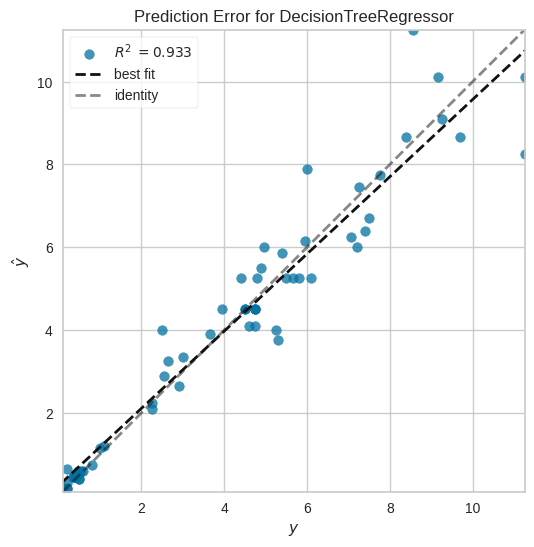

In [23]:
visualizer = RadViz(size=(720, 600))

model = pipe_model
visualizer = PredictionError(model)
visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show();

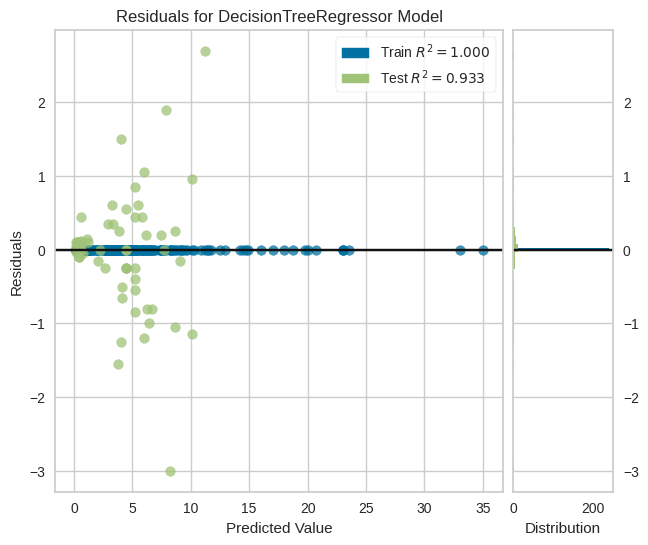

In [24]:
visualizer = RadViz(size=(720, 600))
model = pipe_model
visualizer = ResidualsPlot(model)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show();

In [25]:
print(len(df[df.Selling_Price > 10]))

28


In [26]:
print(28 / 301)

0.09302325581395349


In [27]:
df2 = df[df.Selling_Price < 10]
df2.head()

,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner,Vehicle_Age
0,3.350,5.590,27000,Petrol,Dealer,Manual,0,11
1,4.750,9.540,43000,Diesel,Dealer,Manual,0,12
2,7.250,9.850,6900,Petrol,Dealer,Manual,0,8
3,2.850,4.150,5200,Petrol,Dealer,Manual,0,14
4,4.600,6.870,42450,Diesel,Dealer,Manual,0,11


In [28]:
X = df2.drop(columns="Selling_Price")
y = df2.Selling_Price

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

In [30]:
operations = [("OrdinalEncoder", column_trans),
              ("DT_model", DecisionTreeRegressor(random_state=101))]

pipe_model = Pipeline(steps=operations)

pipe_model.fit(X_train, y_train)

Pipeline(steps=[('OrdinalEncoder',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinalencoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  Index(['Fuel_Type', 'Seller_Type', 'Transmission'], dtype='object'))])),
                ('DT_model', DecisionTreeRegressor(random_state=101))])

In [31]:
train_val(pipe_model, X_train, y_train, X_test, y_test)

,train,test
R2,1.000,0.935
mae,0.000,0.493
mse,0.000,0.533
rmse,0.000,0.730


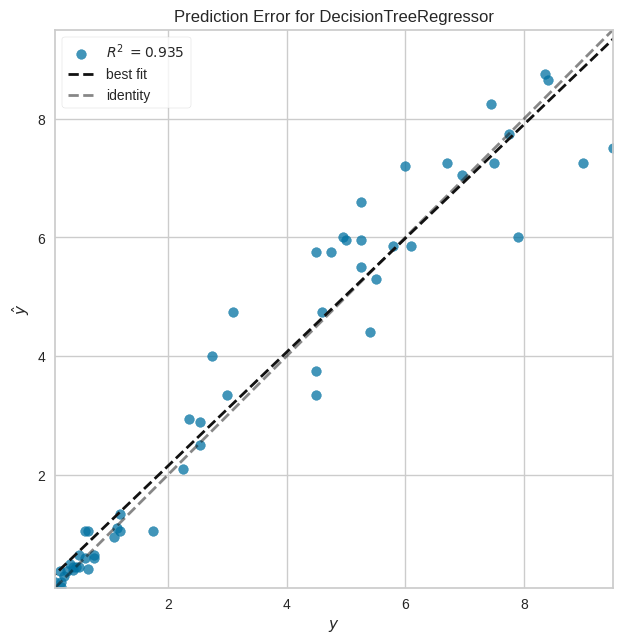

In [32]:
visualizer = RadViz(size=(720, 3000))

model = pipe_model
visualizer = PredictionError(model)
visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show();

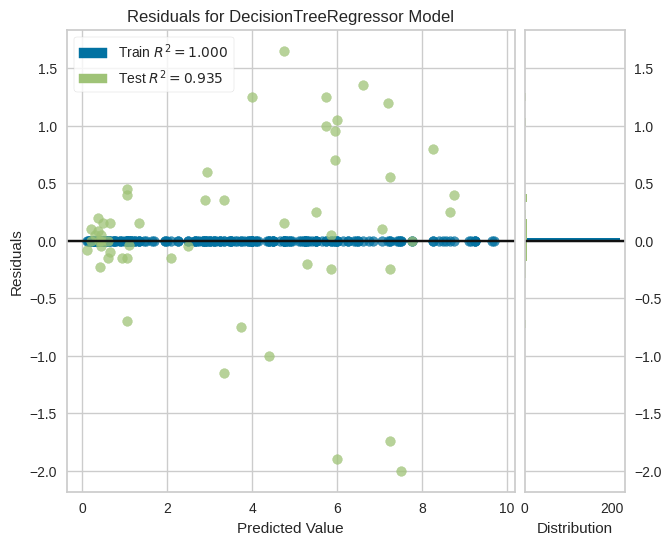

In [33]:
from yellowbrick.regressor import ResidualsPlot

visualizer = RadViz(size=(720, 600))
model = pipe_model
visualizer = ResidualsPlot(model)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show();

In [34]:
operations = [("OrdinalEncoder", column_trans),
              ("DT_model", DecisionTreeRegressor(random_state=101))]
pipe_model = Pipeline(steps=operations)
pipe_model.fit(X_train, y_train)

scores = cross_validate(pipe_model,
                        X_train,
                        y_train,
                        scoring=[
                            'r2', 
                            'neg_mean_absolute_error',
                            'neg_mean_squared_error',
                            'neg_root_mean_squared_error'
                        ],
                        cv=10,
                        return_train_score=True)

df_scores = pd.DataFrame(scores)
df_scores.mean()[2:]

test_r2                              0.892
train_r2                             1.000
test_neg_mean_absolute_error        -0.534
train_neg_mean_absolute_error        0.000
test_neg_mean_squared_error         -0.701
train_neg_mean_squared_error         0.000
test_neg_root_mean_squared_error    -0.814
train_neg_root_mean_squared_error    0.000
dtype: float64

## <font color='orange'> <b>Overfitting Risk and Features Importance</b><font color='white'>  

In [35]:
pipe_model["DT_model"].feature_importances_

array([8.72315324e-03, 9.97470116e-04, 1.82731815e-03, 8.39118154e-01,
       2.14765459e-02, 1.55162018e-05, 1.27841843e-01])

In [36]:
features = pipe_model["OrdinalEncoder"].get_feature_names_out()
features

array(['ordinalencoder__Fuel_Type', 'ordinalencoder__Seller_Type',
       'ordinalencoder__Transmission', 'remainder__Present_Price',
       'remainder__Kms_Driven', 'remainder__Owner',
       'remainder__Vehicle_Age'], dtype=object)

In [37]:
new_features = [i.replace("ordinalencoder__", "").replace("remainder__", "") for i in features]
new_features

['Fuel_Type',
 'Seller_Type',
 'Transmission',
 'Present_Price',
 'Kms_Driven',
 'Owner',
 'Vehicle_Age']

In [38]:
df_fi = pd.DataFrame(
    data=pipe_model["DT_model"].feature_importances_,
    index=new_features,  #index=X.columns
    columns=["Feature Importance"])
df_fi = df_fi.sort_values("Feature Importance", ascending=False)

df_fi

,Feature Importance
Present_Price,0.839
Vehicle_Age,0.128
Kms_Driven,0.021
Fuel_Type,0.009
Transmission,0.002
Seller_Type,0.001
Owner,0.000


In [39]:
pd.DataFrame(pipe_model["OrdinalEncoder"].fit_transform(X_train),
             columns=new_features)

,Fuel_Type,Seller_Type,Transmission,Present_Price,Kms_Driven,Owner,Vehicle_Age
0,2.000,1.000,1.000,0.540,14000.000,0.000,9.000
1,2.000,0.000,1.000,4.600,22517.000,0.000,14.000
2,2.000,0.000,1.000,5.900,9800.000,0.000,12.000
3,1.000,0.000,1.000,9.400,49000.000,0.000,12.000
4,2.000,0.000,1.000,18.610,72000.000,0.000,13.000
5,2.000,1.000,1.000,0.870,15000.000,0.000,9.000
6,2.000,0.000,1.000,7.600,50456.000,0.000,19.000
7,2.000,0.000,1.000,6.760,40000.000,0.000,11.000
8,2.000,1.000,1.000,2.400,7000.000,0.000,11.000
9,2.000,1.000,1.000,2.280,127000.000,0.000,22.000


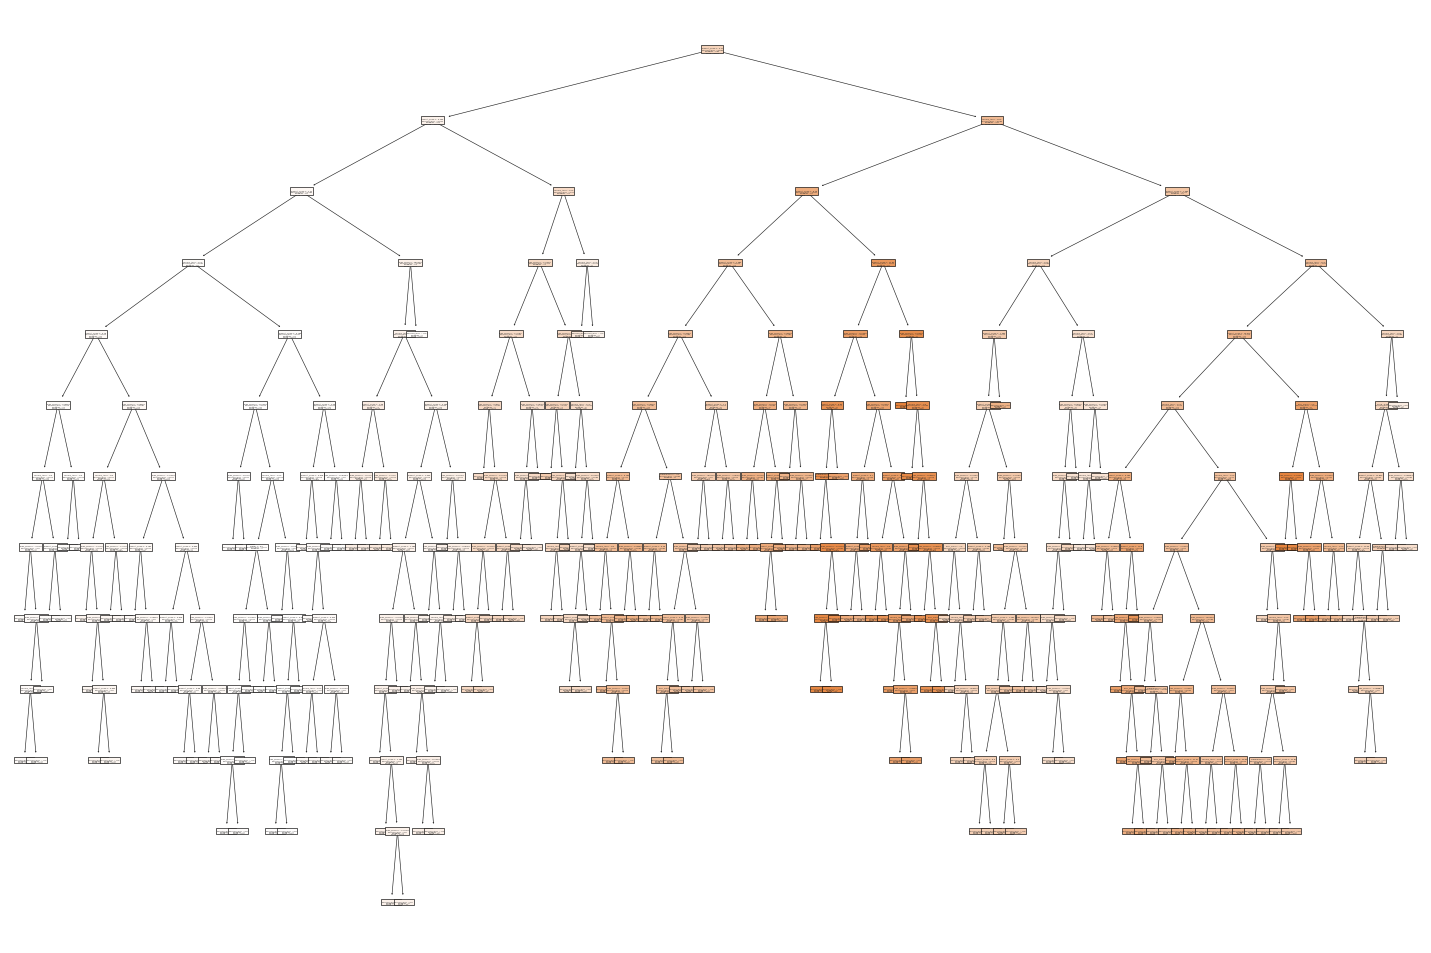

In [40]:
plt.figure(figsize=(12, 8), dpi=150)
plot_tree(pipe_model["DT_model"], filled=True, feature_names=new_features);

In [41]:
def report_model(model):
    y_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)
    print('\n')
    print(train_val(model, X_train, y_train, X_test, y_test))
    print('\n')
    plt.figure(figsize=(12, 8), dpi=100)
    plot_tree(model["DT_model"],
              filled=True,
              feature_names=new_features,
              fontsize=8)



      train  test
R2    0.873 0.928
mae   0.591 0.524
mse   0.874 0.589
rmse  0.935 0.768




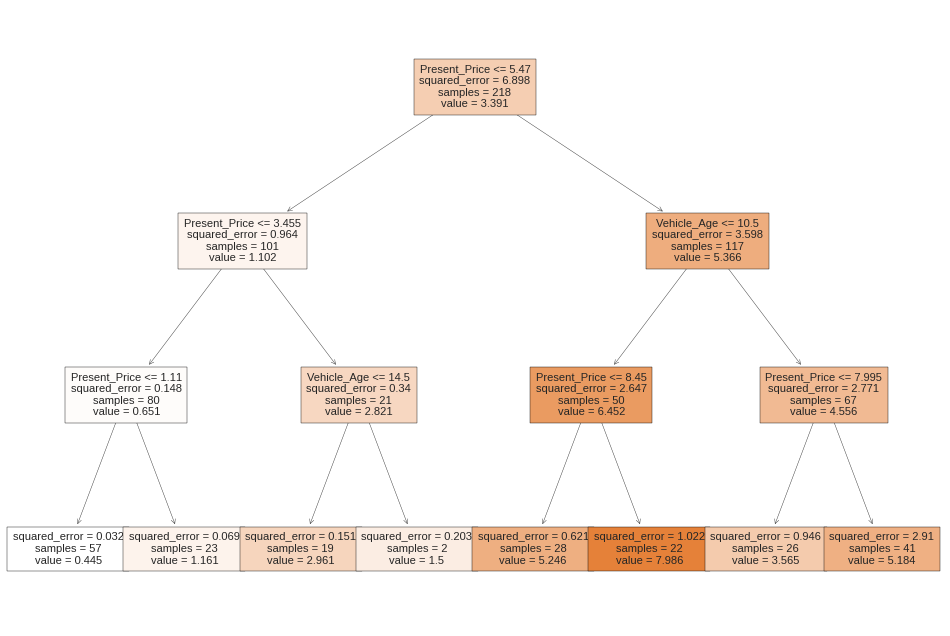

In [42]:
operations = [("OrdinalEncoder", column_trans),
              ("DT_model",
               DecisionTreeRegressor(criterion='squared_error',
                                     max_depth=3,
                                     random_state=101))]

pruned_tree = Pipeline(steps=operations)
pruned_tree.fit(X_train, y_train)

report_model(pruned_tree)

## <font color='orange'> <b>GridSearchCV</b><font color='white'>  

In [43]:
operations = [("OrdinalEncoder", column_trans),
              ("DT_model", DecisionTreeRegressor(random_state=101))]

pipe_model = Pipeline(steps=operations)

In [44]:
param_grid = {
    "DT_model__splitter": ["best", "random"],
    "DT_model__criterion": ["squared_error", "friedman_mse", "absolute_error"],
    "DT_model__max_depth": [2, 3,],
    "DT_model__min_samples_leaf": [1, 2, 3],
    "DT_model__min_samples_split": [2, 3],
    "DT_model__max_features": [4, 5, None]
}

In [45]:
grid_model = GridSearchCV(estimator=pipe_model,
                          param_grid=param_grid,
                          scoring='neg_root_mean_squared_error',
                          cv=10,
                          n_jobs=-1,
                          return_train_score=True)

grid_model.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('OrdinalEncoder',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ordinalencoder',
                                                                         OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                        unknown_value=-1),
                                                                         Index(['Fuel_Type', 'Seller_Type', 'Transmission'], dtype='object'))])),
                                       ('DT_model',
                                        DecisionTreeRegressor(random_state=101))]),
             n_jobs=-1,
             param_grid={'DT_model__criterion': ['squared_error',
                                                 'friedman_mse',
                                                 'absolute_error'],
                         'DT_model__max_depth': [2, 3],
                         'DT_model__max_features': [4, 5, None],
                         'DT_model__min_samples_leaf': [1, 2, 3],
                         'DT_model__min_samples_split': [2, 3],
                         'DT_model__splitter': ['best', 'random']},
             return_train_score=True, scoring='neg_root_mean_squared_error')

In [46]:
grid_model.best_estimator_ 

Pipeline(steps=[('OrdinalEncoder',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinalencoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  Index(['Fuel_Type', 'Seller_Type', 'Transmission'], dtype='object'))])),
                ('DT_model',
                 DecisionTreeRegressor(criterion='absolute_error', max_depth=3,
                                       random_state=101))])

In [47]:
grid_model.best_params_

{'DT_model__criterion': 'absolute_error',
 'DT_model__max_depth': 3,
 'DT_model__max_features': None,
 'DT_model__min_samples_leaf': 1,
 'DT_model__min_samples_split': 2,
 'DT_model__splitter': 'best'}

In [48]:
train_val(grid_model, X_train, y_train, X_test, y_test)

,train,test
R2,0.861,0.877
mae,0.621,0.700
mse,0.957,1.010
rmse,0.978,1.005


# <font color='orange'> <b>Final Model & Prediction</b><font color='white'>  

In [49]:
operations = [("Ordinalcoder", column_trans),
              ("DT_model",
               DecisionTreeRegressor(criterion="absolute_error",
                                     max_depth=3,
                                     random_state=101))]

final_model = Pipeline(steps=operations)

final_model.fit(X, y)

Pipeline(steps=[('Ordinalcoder',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinalencoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  Index(['Fuel_Type', 'Seller_Type', 'Transmission'], dtype='object'))])),
                ('DT_model',
                 DecisionTreeRegressor(criterion='absolute_error', max_depth=3,
                                       random_state=101))])

In [50]:
my_dict = {"Present_Price": [6.5, 9],
           "Kms_Driven": [22000, 41000],
           "Fuel_Type":["Petrol", "Diesel"],
           'Seller_Type':['Dealer', 'Individual'],
           'Transmission': ['Manual', 'Automatic'],
           "Owner":[0,1],
           "Vehicle_Age":[2, 8]}

In [51]:
new_data = pd.DataFrame(my_dict)
new_data

,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner,Vehicle_Age
0,6.500,22000,Petrol,Dealer,Manual,0,2
1,9.000,41000,Diesel,Individual,Automatic,1,8


In [52]:
final_model.predict(new_data)

array([4.65, 6.9 ])